**注意:下面使用的所有数据点向量，包括x、t均为行向量；所有权重向量，包括w、alpha和输出y，均为列向量；所有大写的字母，包括X，T均为x和t在列方向上排开后的数据集矩阵。K为对数据集中的n个数据，两两之间做核函数运算后得到的矩阵**
### 从高维映射到核
我们最早接触的机器学习算法是线性回归和逻辑回归；在使用它们时，如果数据需要非线性的曲线拟合或者非线性的曲面划分，我们会对数据进行高维映射，比如用多项式把x映射到Φ(x)。这时的Φ(x)比原来的x维度更高，而原空间无法线性可分的数据，在高维空间更有机会被线性分割。  
而前面也同样提到了，高维映射固然能实现非线性，但是如果原空间的维度已经很高，那映射将花费非常大的计算量，处理映射后的超高维数据一样不轻松(仅仅是对一个1000x1000的矩阵求逆都要花费相当多的时间)。核技巧是为了解决这个问题而提出的。  
核技巧的思想很简单，考虑一个把一维数据映射进行到二次多项式的映射$ \phi(\{x_1,x_2\}) = \{x_1^2,\sqrt{2}x_1 x_2,x_2^2\} $ 我们把它用在某个向量上$x = \{x_1, x_2\}$，就得到$ \phi(x) = \{x_1^2,\sqrt{2}x_1 x_2,x_2^2\}$。然后再对映射后的向量做内积，$ \phi(x)\phi(x)^T = x_1^4+2x_1^2 x_2^2 + x_2^4$。而我们又恰好发现它等于$(x x^T)^2$。这个trivial的例子告诉我们一个很有用的知识，如果我们直接对向量内积下手，就只需要计算一次标量映射，而对原向量展开，要对所有x的元素求向量映射，相比之下要简单很多。  
### 核函数
上面的标量平方的计算就是一种核函数，我们把映射$\phi(x)\phi(y)^T$直接换成运算后得到标量的核函数$k(x,y)$。常用的核函数有高斯核和多项式核。  
$$ k(x,y) = (xy^T)^d $$
$$ k(x,y) = exp(-\sigma||x-y||^2) $$
只要我们能在原来的算法里凑出上面的向量内积形式，就能跳过向量映射的步骤，直接计算标量的映射。具体怎么做呢？以线性最小二乘回归为例。因为w的长度和x的size，也就是数据维度相同。我们先把原来的w改写成所有训练数据的线性组合，设训练样本总数为N，样本点向量为t_i，每个t_i的权重为alpha_i，则
$$ w = \sum_{i=1}^{N} \alpha_i t_i^T $$
这时原本的线性函数wx就可以写成
$$ y = \sum_{i=1}^{N} \alpha_i x t_i^T $$
我们使用映射函数Φ映射变换$ x和t_i^T $，就有核函数的形式了。
$$ y = \sum_{i=1}^{N} \alpha_i \phi(x) \phi(t_i)^T = \sum_{i=1}^{N} \alpha_n k(x,t_i) $$
也可以改写成向量形式。设数据集T是长为N，宽，也就是每个样本的维度为m的矩阵。则这里的k(x,T)是长度为N的行向量，alpha是长度为N的列向量。
$$ y = k(x,T) \alpha $$
到这里，我们就把求解线性函数的权重向量w的问题，转变成了求解训练样本权重alpha的问题。虽然N是样本总数可能很大，但比起寻找映射函数→对向量做映射→求解的过程还是简单了很多。
### 核线性回归
把这个式子代入线性回归最小化均方误差的最优化问题里，上式中的x就也是样本点t_i。
$$ L(\alpha) = \frac{1}{2N} \sum_{n=1}^{N} (k(t_i,T) \alpha-y_i)^2 $$
如果我们把样本点之间两两通过核函数计算内积的数值画在一张矩阵里(称为核矩阵)，上面的等式还能进一步化简。
$$ K_{(nxn)}[i][j] = k(t_i,t_j) $$
$$ L(\alpha) = \frac{1}{2N} (K \alpha-y)^T (K \alpha-y) $$
对alpha求偏导计算梯度，让梯度为零就得到极值点，也就是我们核函数的最小二乘闭式解。
$$ \frac{\partial L}{\partial \alpha}= \frac{1}{N}K^T(K\alpha-y)=0 $$
$$ \alpha= (K^TK)^{-1}K^Ty $$
对比下之前非核的最小二乘的公式
$$ W = (X^{T}X)^{-1}(X^Ty) $$
就会发现形式非常相似，只不过我们现在求解的是alpha，并把矩阵X用核矩阵K代替掉了而已。类似的我们也可以引入正则化项防止过拟合。
$$ \alpha = (K^TK+\lambda I)^{-1}K^Ty $$
核线性回归的推导到此结束，我们实践一下，看一看核最小二乘能否表现出非线性。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets

In [2]:
# 这里给出两种常用的核函数，高斯核和多项式核

def gus_kernel(x1, x2, sigma = None):
    '''
    输入x1为(m,)的向量，x2为(n,m)的矩阵
    '''
    if sigma==None:
        sigma = 0.5/len(x1)
    square = np.sum((x2-x1)**2,axis = 1)
    return np.exp(-square*sigma)

def poly_kernel(x1, x2, d=1):
    return np.sum(x1*x2,axis = 1)**d

In [3]:
x1 = np.array([0.5,-0.5])
x2 = np.array([[1,2],[3,4],[5,6]])
print(gus_kernel(x1,x2))
print(poly_kernel(x1,x2,2))

[1.96911675e-01 1.32678043e-03 1.63737713e-07]
[0.25 0.25 0.25]


In [4]:
def evaluate(x, X, alpha, k, k_c):
    '''
    X是训练alpha使用的数据集，x是要计算的向量
    k和k_c分别是核函数和核函数的系数
    '''
    return k(x,X,k_c).dot(alpha)
    

def kernel_fit(X_raw, y, lamda = 0, kernel = "gus", k_c = None, plot = False):
    n,m = X_raw.shape
    X = X_raw
    # X = np.concatenate((X_raw,np.ones((n,1))),axis = 1)
    
    if kernel=="gus":
        k = gus_kernel
    elif kernel=="poly":
        k = poly_kernel
    else:
        print("No such kernel function")
        return
    
    # 计算核矩阵
    K = [k(X[i],X,k_c) for i in range(n)]
    K = np.array(K)
    alpha = np.linalg.inv(K.T.dot(K)+lamda*np.eye(n)).dot(K.T.dot(y))
    
    if plot:
        if m>1:
            print("Can not plot data more than 1 dimension.")
        else:
            plt.figure()
            x_space = np.linspace(np.min(X_raw),np.max(X_raw),100).reshape(-1,1)
            y_space = [evaluate(x, X, alpha, k, k_c) for x in x_space]
            plt.plot(x_space, y_space)
            plt.scatter(X_raw.squeeze(), y.squeeze(), c = 'r', marker = 'x')
        
    return X,alpha

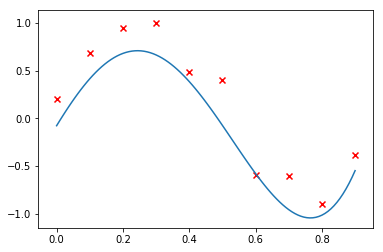

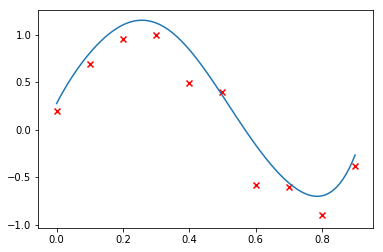

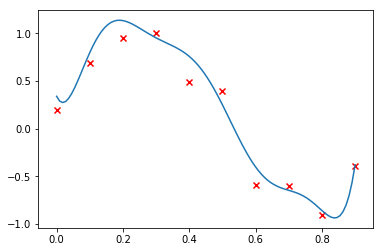

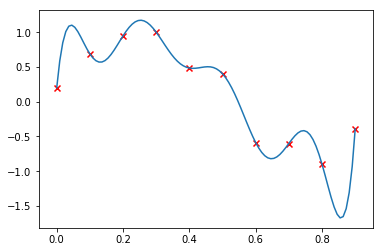

In [5]:
X = np.linspace(0,0.9,10).reshape(-1,1)
y = np.sin(X*2*np.pi)
y += np.array([0.2, 0.1, 0, 0.05, -0.1, 0.4, 0, 0.35, 0.05, 0.2]).reshape(-1,1)

X,alpha = kernel_fit(X, y, lamda = 0, kernel = "gus", k_c = 1, plot = True)
X,alpha = kernel_fit(X, y, lamda = 0, kernel = "gus", k_c = 2, plot = True)
X,alpha = kernel_fit(X, y, lamda = 0, kernel = "gus", k_c = 4, plot = True)
X,alpha = kernel_fit(X, y, lamda = 0, kernel = "gus", k_c = 8, plot = True)

### 核逻辑回归
从上面的回归问题里容易看出，引入不同的核函数，就相当于把原数据投影到了不同的高维的空间，再做线性回归。而这种强大的非线性能力如果能用于分类，应该会表现的非常好。和上面的方法类似，我们把线性组合变成alpha+核函数的形式，并把这个新的y代入sigmoid函数，得到分类为正的概率
$$ p = \sigma(k(x,T) \alpha) $$
$$ argmax\quad L(\alpha)=\frac{1}{N}\sum_{i=1}^{n}(y_i log(p)+(1-y_i) log(1-p)) $$
仍然用梯度下降法进行优化计算，为此需要计算BCEloss二分类交叉熵损失函数关于alpha的导数$\partial{L}/\partial{\alpha}$
$$ \frac{\partial{L}}{\partial{\alpha}}=\frac{1}{N}K^{T}(y-p)$$

In [6]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

class Logisic_kernel:
    def __init__(self, lamda = 0, kernel = "gus", k_c = None):
        self.X = None
        self.alpha = None
        if kernel=="gus":
            self.k = gus_kernel
        elif kernel=="poly":
            self.k = poly_kernel
        else:
            print("No such kernel function")
        self.k_c = k_c
    
    def fit(self,X,y,lr = 0.01,max_iter = 500, print_every_iters = 100):
        n,m = X.shape
        self.X = X
        y = y.reshape(-1,1)
        self.alpha = np.random.rand(n,1)*0.01
        # 计算核矩阵
        K = [self.k(X[i],X,self.k_c) for i in range(n)]
        K = np.array(K)
        
        for iters in range(max_iter):
            p = sigmoid(K.dot(self.alpha)) # 计算概率
            if (iters+1)%print_every_iters==0:
                err = np.mean(-y*np.log(p)-(1-y)*np.log(1-p))  # BCE loss
                print("Iteration: %d, BCE loss: %.2f"%(iters+1,err))
            do = p-y # BCE loss的梯度计算
            da = K.T.dot(do)/n
            # 梯度下降
            self.alpha -= lr*da
    
    def predict(self, X):
        ret = [evaluate(x,self.X,self.alpha,self.k,self.k_c)[0] for x in X]
        return np.round(sigmoid(np.array(ret)))

In [7]:
X,y = datasets.load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, random_state = 0)

#数据标准化处理
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [8]:
klr = Logisic_kernel()
klr.fit(X_train,y_train,lr = 0.05,max_iter=2000,print_every_iters = 200)

Iteration: 200, BCE loss: 0.14
Iteration: 400, BCE loss: 0.12
Iteration: 600, BCE loss: 0.11
Iteration: 800, BCE loss: 0.10
Iteration: 1000, BCE loss: 0.10
Iteration: 1200, BCE loss: 0.10
Iteration: 1400, BCE loss: 0.09
Iteration: 1600, BCE loss: 0.09
Iteration: 1800, BCE loss: 0.09
Iteration: 2000, BCE loss: 0.09


In [9]:
accuracy_score(klr.predict(X_test),y_test)

0.9473684210526315

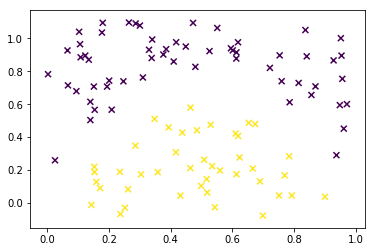

In [10]:
# 设计不是线性可分的数据集
X = np.random.rand(2,100)
y = (X[1]<np.sin(X[0]*np.pi)*0.7)
y = y.astype(np.int)
X = X.T
X[np.where(y==0),1] += 0.1
X[np.where(y==1),1] -= 0.1

plt.scatter(X[:,0].squeeze(),X[:,1].squeeze(),c=y, marker='x')

In [11]:
def decision_plain(model, low1, upp1, low2, upp2):
    x_axis = np.linspace(low1,upp1,100)
    y_axis = np.linspace(low2,upp2,100)
    xx, yy = np.meshgrid(x_axis, y_axis)
    Z = np.zeros((100,100))
    for i in range(100):
        for j in range(100):
            
            Z[i][j] = model.predict(np.array([[xx[i][j],yy[i][j]]]))
    plt.figure(figsize=(8,6), dpi=80)
    colors = ['aquamarine','palegoldenrod']
    plt.contourf(xx, yy, Z, cmap=matplotlib.colors.ListedColormap(colors))

Iteration: 1000, BCE loss: 0.05
Iteration: 2000, BCE loss: 0.03
Iteration: 3000, BCE loss: 0.03
Iteration: 4000, BCE loss: 0.02
Iteration: 5000, BCE loss: 0.02
Accuracy: 100.0


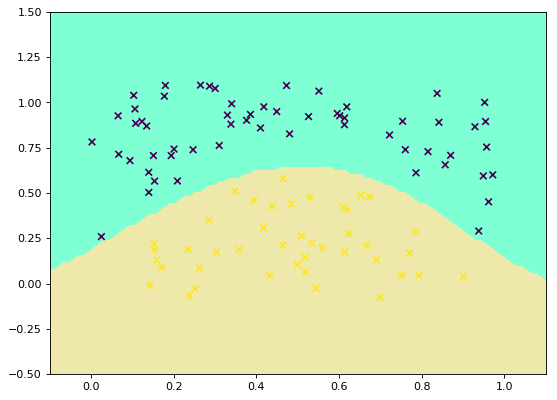

In [12]:
model = Logisic_kernel(k_c = 10)
model.fit(X,y,lr = 0.05,max_iter=5000,print_every_iters = 1000)
print("Accuracy:",accuracy_score(model.predict(X),y)*100)
decision_plain(model,-0.1,1.1,-0.5,1.5)
plt.scatter(X[:,0].squeeze(),X[:,1].squeeze(),c=y, marker='x')

### 核SVM
SVM支持向量机，又被称作大间隔分类器。一般使用的SVM都是软间隔SVM，它的损失函数额外多出了一项，会在|o-y|小于1时施加额外的hinge loss，与此同时，惩罚w以最小化|o-y|。这样的loss function最终求解得到的分类平面会让它到两类样本的最近距离相同。设正样本的y为1，负样本为-1，则线性SVM的损失函数为
$$ L(w) = \frac{||w||^2}{2}+C\sum_{i=1}^{N}ReLU[1-y_i(x_iw+b)] $$
这种大间隔机有很好的抗干扰能力，为了让线性SVM获得非线性，我们一样可以用核技巧把$xw+b$替换成$ k(x,t)\alpha+b $，新的损失函数为
$$ L(w) = \frac{1}{2}\alpha^T K \alpha+C\sum_{i=1}^{N}ReLU[1-y_i(k(x,t)\alpha+b)] $$
右边那项好懂，就是把新的y形式代入；左边那项的话，还记得我们使用核技巧时，把w换成了$ w = \sum_{i=1}^{N}\alpha_i*\phi(t_i)=\phi(t)^T\alpha $，这时$$ ||w||^2 = w^Tw = (\phi(t)^T\alpha)^T(\phi(t)^T\alpha) = \alpha^T\phi(t)\phi(t)^T\alpha = \alpha^T K \alpha $$
上面的线性SVM和核SVM都可以用梯度下降直接优化求解，而核SVM还能用一种启发式+闭式解的SMO算法更快地完成计算，。SMO的高效让SVM直到今天仍然是数据科学中常用的，小数据分析利器。

### RBF神经网络
上面的回归和分类的例子都是用高斯核函数完成的，它基于欧氏距离的平方计算，基于输入向量和中心向量的距离的核函数称为rbf核，两者很类似。RBF核有着非常好的非线性性质，并且其精度可以随带宽sigma无限增大，也就是可以拟合任何函数。比起必须考虑指数爆炸和数值精度的多项式核更好用。因为RBF核拥有的强大非线性能力，有很多直接由RBF衍生的算法，RBF神经网络就是一种。  
说它是神经网络似乎有些牵强，但是它确实很像神经网络。
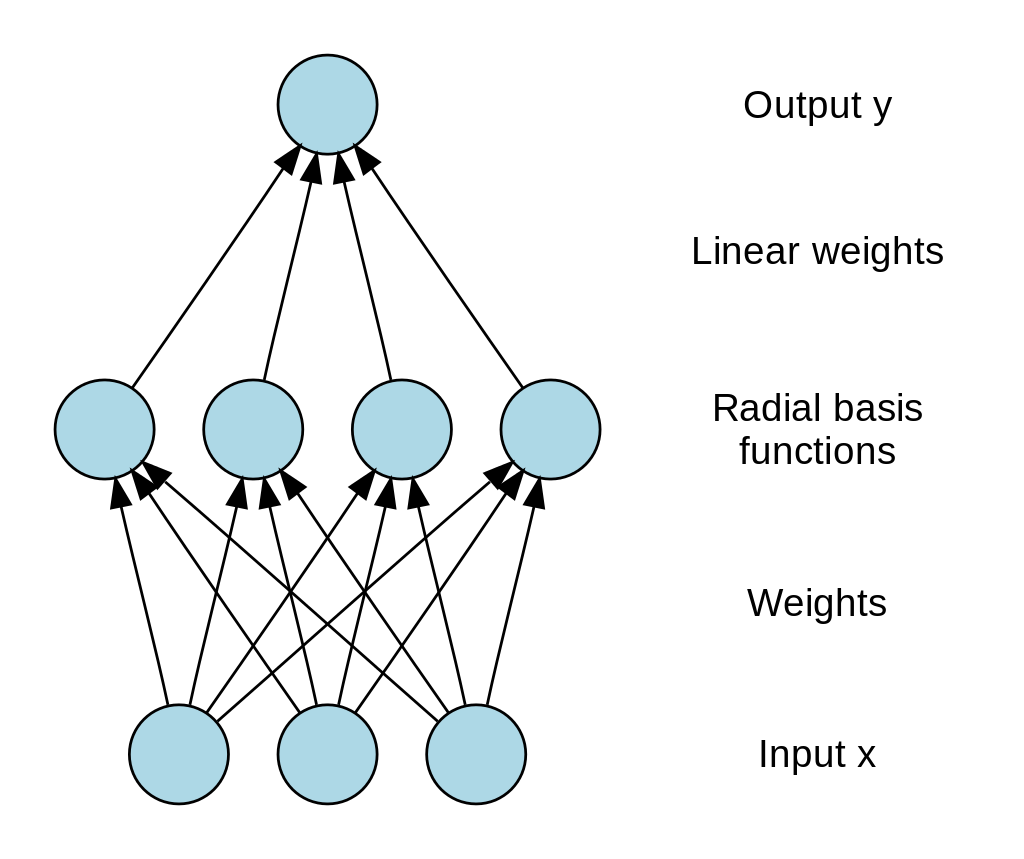
但这东西只是看起来像神经网络，它的数学性质和我们熟知的前馈nn截然不同。它的公式写做
$$ \phi(x) = \sum_{i=1}^{q} w_i\rho(x,c_i)  $$
首先我们在隐层里存很多样本，这些样本可以采样得到，也可以聚类得到。依次计算它们与输入样本的径向基，然后以一定权重组合起来，事实上这个过程就是我们之前实现一般核方法的过程，但是这里的径向基核带宽是可以让模型自行学习的。我们可以将这样的径向基层叠成深度网络(虽然这么做意义不大，因为RBF已经具有了无穷的精度)。这个方法比一般的前馈网络强在局部逼近的能力，当一个隐层样本和输入相似时，径向基函数输出接近1的数值，其他不那么接近的隐层样本输出比较小的数值，如0.1，0.01，然后它们被乘上一个权重作为输出。这就相当于很多个给定均值的，方差和权重可以被调节的高斯混合模型，但是并没有概率模型的归一化限制。因为rbf函数是平滑的，所以只要我们在目标区域的采样足够多，就能得到相当好的在目标区域的函数逼近能力。  
这个东西我们也不需要深度了解，下面简单做一个能实现异或功能的RBF网络，供我们理解RBF网络的工作原理。在实现之前，还是先敲一下反向传播的公式。  
我们使用均方误差拟合标量单输出的函数
$$ E(w_i,β_i )=\frac{1}{2} (y ̂-y)^2 \\
\frac{∂E}{∂y}=y-y ̂\\
\frac{∂y}{∂w_i}=ρ(x_i,c_i)\\
\frac{∂y}{∂ρ_i }=w_i\\
\frac{∂ρ_i}{∂β_i}=-\lvert{x_i-c_i}\lvert·ρ_i\\
\frac{∂E}{∂w_i}=(y-y ̂ )*ρ(x_i,c_i)\\
\frac{∂E}{∂β_i}=(y-y ̂ )*ρ(x_i,c_i )*(-\lvert x_i-c_i \lvert)\\
$$

In [13]:
def RBF(r,b):
    return np.exp(-b*(r))

def radius(x, c):
    '''
    输入x，中心向量c
    '''
    return np.linalg.norm(x-c)
     
class RBFNetwork:
    def __init__(self, centers, output_sz):
        '''
        输入centers:结点使用的基向量
        给定几个基向量就生成几个结点
        output_size是输出的维度
        '''
        self.input_sz = len(centers[0])
        self.hidden_sz = len(centers)
        self.output_sz = output_sz
        self.centers = centers
        self.w = np.random.randn(self.hidden_sz,output_sz)*0.1
        self.beta = np.random.rand(self.hidden_sz)*0.1
    
    def forward(self, x):
        hidden_out = []
        rs = []
        for i in range(self.hidden_sz):
            r = radius(x,self.centers[i])
            out = RBF(r,self.beta[i])
            rs.append(r)
            hidden_out.append(out)
        self.rhos = np.array(hidden_out)
        self.radius = np.array(rs)
        self.y = self.rhos.dot(self.w)
        return self.y
    
    def backward(self, yhat, lr_w=0.1, lr_b = 0.01):
        delta = (self.y-yhat)
        # 计算导数
        dw = self.rhos[np.newaxis, :].T.dot(delta[np.newaxis, :])
        db = -delta.dot(self.w.T)*self.rhos*self.radius
        # 更新参数
        self.w -= lr_w*dw
        self.beta -= lr_b*db
        # 注意，beta不能小于0，要做clip
        self.beta = np.clip(self.beta,0,None)
        return

In [14]:
x_axis = np.linspace(0,1,11)
y_axis = np.linspace(0,1,11)
data = np.array([(x_axis[i],y_axis[j]) for i in range(11) for j in range(11)])
y = np.array([np.round(i).astype(np.int)^np.round(j).astype(np.int) for i,j in data])

def Error(model):
    err = 0
    for i in range(len(data)):
        err+=0.5*(y[i]-model.forward(data[i]))**2
    return err

In [15]:
centers = np.array([[0.1,0.3],[0.3,0.1],
                   [0.9,0.7],[0.7,0.9],
                   [0.4,0.6],[0.6,0.4]])
# 这里我们手动给定各隐层中心，以更好观察分布

model = RBFNetwork(centers,1)
for t in range(50000):
    idx = random.randint(0,len(data)-1)
    model.forward(data[idx])
    model.backward(y[idx],0.05,0.01)
    if (t+1)%5000==0:
        err = Error(model)
        print("Iteration:%d, Error: %.2f"%(t+1,err))

Iteration:5000, Error: 14.06
Iteration:10000, Error: 10.87
Iteration:15000, Error: 6.25
Iteration:20000, Error: 5.42
Iteration:25000, Error: 5.14
Iteration:30000, Error: 5.08
Iteration:35000, Error: 4.94
Iteration:40000, Error: 5.28
Iteration:45000, Error: 5.70
Iteration:50000, Error: 5.04


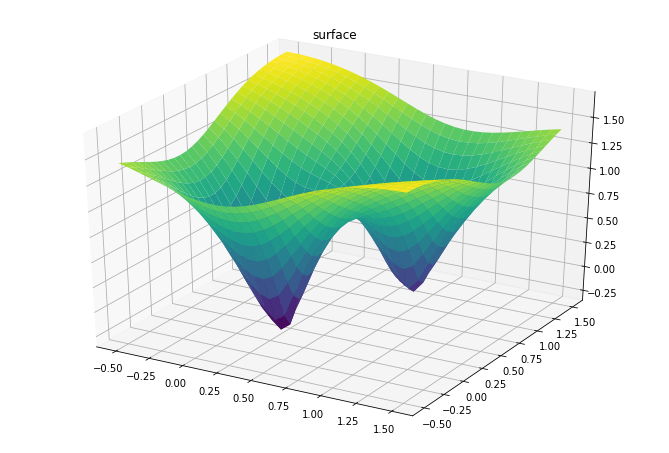

In [16]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import pyplot as plt
xx = np.linspace(-0.5,1.5,30)
yy = np.linspace(-0.5,1.5,30)
X,Y = np.meshgrid(xx,yy)

Z = np.zeros(X.shape)
for i in range(len(X)):
    for j in range(len(X[0])):
        x = np.array((X[i][j],Y[i][j]))
        Z[i][j] = model.forward(x)

fig = plt.figure(figsize=(9,6))
ax = Axes3D(fig)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('surface')
plt.show()

从上图可以观察到，RBF网络的本质就是在每一个输出维度，在给定的几个中心向量处形成，均值固定，权重不固定，方差不固定的高斯分布簇。其中权重核方差可以用梯度下降根据样本分布进行学习。我们认为它也是一种核方法，而且从RBF网络的角度，我们可以看到一种不同于上面的高维低维映射的解释，即基于高斯核的核方法，可以解释成多个高斯分布在几何空间中，按照不同权重的混合产物。